# Autonomous Vehicle Coordination: MADDPG for Traffic Management

## Introduction

In this notebook, we'll implement a Multi-Agent Reinforcement Learning (MARL) solution for autonomous vehicle coordination in an urban traffic scenario. We'll use the Multi-Agent Deep Deterministic Policy Gradient (MADDPG) algorithm, which is well-suited for continuous action spaces and can handle the complex interactions between multiple vehicles.

Our scenario will consist of multiple autonomous vehicles navigating through a simplified urban environment, with the goals of reaching their destinations efficiently while avoiding collisions.

## Environment Setup

First, let's set up our environment. We'll create a simple 2D grid-based urban environment with roads, intersections, and destination points.

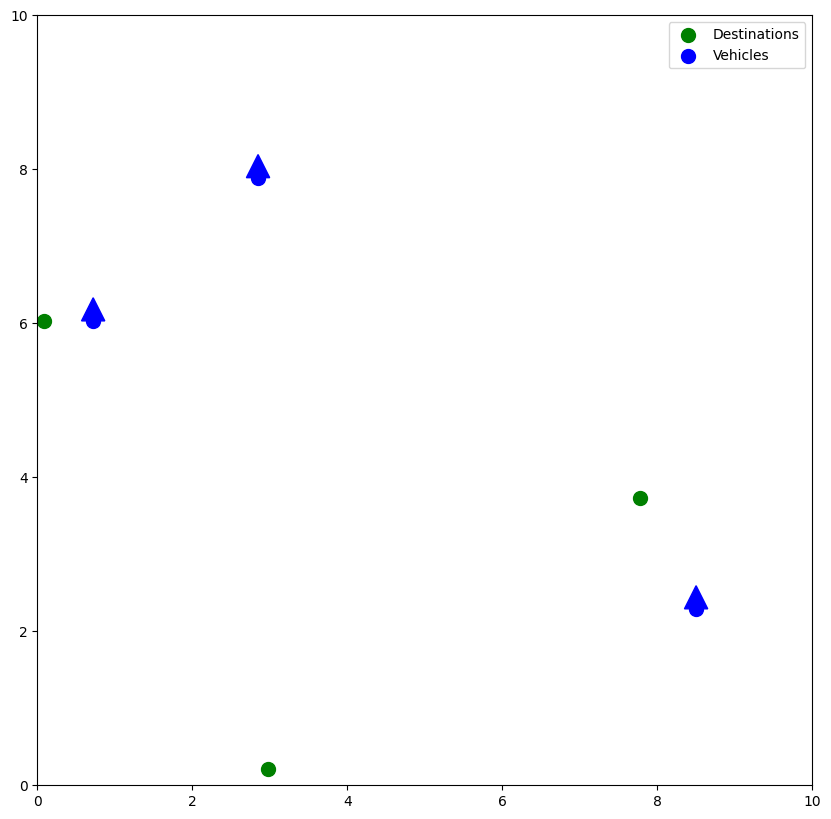

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
import torch
import torch.nn as nn
import torch.optim as optim
import random

class UrbanEnvironment:
    def __init__(self, size: int, n_vehicles: int, n_destinations: int):
        self.size = size
        self.n_vehicles = n_vehicles
        self.n_destinations = n_destinations
        self.reset()

    def reset(self) -> np.ndarray:
        self.vehicle_positions = np.random.rand(self.n_vehicles, 2) * self.size
        self.vehicle_velocities = np.zeros((self.n_vehicles, 2))
        self.destinations = np.random.rand(self.n_destinations, 2) * self.size
        self.collisions = np.zeros(self.n_vehicles, dtype=bool)
        return self._get_observations()

    def step(self, actions: np.ndarray) -> Tuple[np.ndarray, np.ndarray, bool, dict]:
        # Update velocities and positions
        self.vehicle_velocities += actions
        self.vehicle_velocities = np.clip(self.vehicle_velocities, -1, 1)
        self.vehicle_positions += self.vehicle_velocities

        # Wrap around environment edges
        self.vehicle_positions %= self.size

        # Check for collisions
        self.collisions = self._check_collisions()

        # Calculate rewards
        rewards = self._calculate_rewards()

        # Check if all vehicles have reached destinations
        done = np.all([self._vehicle_at_destination(i) for i in range(self.n_vehicles)])

        return self._get_observations(), rewards, done, {}

    def _get_observations(self) -> np.ndarray:
        obs = np.zeros((self.n_vehicles, 4 + 2 * (self.n_vehicles - 1) + 2 * self.n_destinations))
        for i in range(self.n_vehicles):
            obs[i, :2] = self.vehicle_positions[i]
            obs[i, 2:4] = self.vehicle_velocities[i]
            other_vehicles = np.delete(self.vehicle_positions, i, axis=0)
            obs[i, 4:4+2*(self.n_vehicles-1)] = other_vehicles.flatten()
            obs[i, -2*self.n_destinations:] = self.destinations.flatten()
        return obs

    def _check_collisions(self) -> np.ndarray:
        collisions = np.zeros(self.n_vehicles, dtype=bool)
        for i in range(self.n_vehicles):
            for j in range(i + 1, self.n_vehicles):
                if np.linalg.norm(self.vehicle_positions[i] - self.vehicle_positions[j]) < 0.5:
                    collisions[i] = collisions[j] = True
        return collisions

    def _calculate_rewards(self) -> np.ndarray:
        rewards = np.zeros(self.n_vehicles)
        for i in range(self.n_vehicles):
            if self.collisions[i]:
                rewards[i] -= 10
            elif self._vehicle_at_destination(i):
                rewards[i] += 20
            else:
                closest_dest = np.argmin(np.linalg.norm(self.vehicle_positions[i] - self.destinations, axis=1))
                distance = np.linalg.norm(self.vehicle_positions[i] - self.destinations[closest_dest])
                rewards[i] -= distance / self.size
        return rewards

    def _vehicle_at_destination(self, vehicle_idx: int) -> bool:
        return np.any(np.linalg.norm(self.vehicle_positions[vehicle_idx] - self.destinations, axis=1) < 0.5)

    def render(self):
        plt.figure(figsize=(10, 10))
        plt.xlim(0, self.size)
        plt.ylim(0, self.size)
        plt.scatter(self.destinations[:, 0], self.destinations[:, 1], c='g', s=100, label='Destinations')
        plt.scatter(self.vehicle_positions[:, 0], self.vehicle_positions[:, 1], c='b', s=100, label='Vehicles')
        for i, pos in enumerate(self.vehicle_positions):
            plt.arrow(pos[0], pos[1], self.vehicle_velocities[i, 0], self.vehicle_velocities[i, 1], 
                      head_width=0.3, head_length=0.3, fc='b', ec='b')
        plt.legend()
        plt.show()

# Test the environment
env = UrbanEnvironment(size=10, n_vehicles=3, n_destinations=3)
obs = env.reset()
env.render()

## MADDPG Implementation

Now that we have our environment, let's implement the MADDPG algorithm. We'll create actor and critic networks, as well as the MADDPG agent class.

In [2]:
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, n_agents):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim * n_agents + action_dim * n_agents, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
        
    def forward(self, states, actions):
        x = torch.cat([states, actions], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class MADDPGAgent:
    def __init__(self, state_dim, action_dim, n_agents):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.n_agents = n_agents
        
        self.actor = Actor(state_dim, action_dim)
        self.critic = Critic(state_dim, action_dim, n_agents)
        self.target_actor = Actor(state_dim, action_dim)
        self.target_critic = Critic(state_dim, action_dim, n_agents)
        
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.target_critic.load_state_dict(self.critic.state_dict())
        
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=0.01)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=0.01)
        
        self.memory = []
        self.max_memory_size = 10000
        self.batch_size = 64
        self.gamma = 0.95
        self.tau = 0.02
        
    def get_action(self, state):
        state = torch.FloatTensor(state)
        action = self.actor(state).detach().numpy()
        return action
    
    def update(self, states, actions, rewards, next_states, dones):
        self.memory.append((states, actions, rewards, next_states, dones))
        if len(self.memory) > self.max_memory_size:
            self.memory.pop(0)
        
        if len(self.memory) < self.batch_size:
            return
        
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)
        
        # Reshape states and actions for the critic input
        states_full = states.view(self.batch_size, -1)
        actions_full = actions.view(self.batch_size, -1)
        next_states_full = next_states.view(self.batch_size, -1)
        
        # Update critic
        with torch.no_grad():
            next_actions = torch.cat([self.target_actor(next_states[:, i]) 
                                      for i in range(self.n_agents)], dim=1)
            Q_targets_next = self.target_critic(next_states_full, next_actions)
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))
        Q_expected = self.critic(states_full, actions_full)
        critic_loss = nn.MSELoss()(Q_expected, Q_targets.detach())
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        # Update actor
        actor_actions = torch.cat([self.actor(states[:, i]) 
                                   for i in range(self.n_agents)], dim=1)
        actor_loss = -self.critic(states_full, actor_actions).mean()
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # Update target networks
        for target_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
            target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)
        
        for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
            target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)

# Initialize environment and agents
env = UrbanEnvironment(size=10, n_vehicles=3, n_destinations=3)
state_dim = 4 + 2 * (env.n_vehicles - 1) + 2 * env.n_destinations
action_dim = 2
agents = [MADDPGAgent(state_dim, action_dim, env.n_vehicles) for _ in range(env.n_vehicles)]

## Training Loop

Now that we have our environment and MADDPG agents set up, let's implement the training loop.

In [3]:
n_episodes = 1000
max_steps = 100
episode_rewards = []

for episode in range(n_episodes):
    state = env.reset()
    episode_reward = 0
    
    for step in range(max_steps):
        actions = np.array([agent.get_action(s) for agent, s in zip(agents, state)])
        
        next_state, rewards, done, _ = env.step(actions)
        episode_reward += sum(rewards)
        
        # Store the experience in each agent's memory
        for agent in agents:
            agent.update(state, actions, rewards, next_state, done)
        
        state = next_state
        
        if done:
            break
    
    episode_rewards.append(episode_reward)
    
    if episode % 100 == 0:
        print(f"Episode {episode}, Avg Reward: {np.mean(episode_rewards[-100:]):.2f}")

# Plot the learning curve
plt.plot(episode_rewards)
plt.title("Learning Curve")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 14 but got size 2 for tensor number 1 in the list.

## Evaluation

Let's evaluate our trained agents by running a few episodes and visualizing their behavior.

In [ ]:
def evaluate(env, agents, n_episodes=5):
    for episode in range(n_episodes):
        state = env.reset()
        done = False
        step = 0
        
        while not done and step < 100:
            env.render()
            actions = [agent.get_action(s) for agent, s in zip(agents, state)]
            actions = np.array(actions)
            state, rewards, done, _ = env.step(actions)
            step += 1
        
        print(f"Episode {episode + 1} finished in {step} steps")

evaluate(env, agents)

## Conclusion

In this notebook, we've implemented an Autonomous Vehicle Coordination scenario using the MADDPG algorithm. We've seen how multiple agents can learn to navigate an urban environment, avoiding collisions and reaching their destinations.

Some observations and potential improvements:

1. The agents learn to navigate the environment and avoid collisions, but their strategies might not be optimal.
2. We could improve the realism of the environment by adding more complex road structures, traffic rules, or dynamic obstacles.
3. The reward function could be refined to encourage more efficient routes or to penalize unnecessary movements.
4. We could experiment with different network architectures or hyperparameters to improve learning performance.
5. Implementing prioritized experience replay or parameter noise for exploration could potentially enhance the learning process.

In the next notebooks, we'll explore even more complex scenarios and advanced MARL techniques to address some of these limitations and tackle different real-world problems.

## References

1. Lowe, R., Wu, Y., Tamar, A., Harb, J., Abbeel, P., & Mordatch, I. (2017). Multi-agent actor-critic for mixed cooperative-competitive environments. In Advances in Neural Information Processing Systems (pp. 6379-6390).
2. Shalev-Shwartz, S., Shammah, S., & Shashua, A. (2016). Safe, multi-agent, reinforcement learning for autonomous driving. arXiv preprint arXiv:1610.03295.